Нарисуем данные коммерческого предприятия для анализа, например, на случай если дали задачу SQL без данных

Нарисовать нужно продажи, то есть, за период нужны записи, содержащие:

- Дату и время продажи
- Клиента
- Товар
- Цену
- Количество
- Скидку на товар
- Скидку на комплект товаров в заказе
- Признак постоянности клиента (регистрация в программе лояльности)

In [1072]:
import pandas as pd
import numpy as np
import datetime
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(rc={'figure.figsize' : (12, 5)}, font='verdana')
plt.style.use('dark_background')

Соберем интервал дат будущей таблицы

In [1073]:
date_start = '2024-05-01' # Начало временного диапазона
date_end = '2024-12-31'   # Конец временного дипазона

In [1074]:
df = pd.DataFrame({'date' : pd.date_range(date_start, date_end)})
df.head(3)

,date
0,2024-05-01
1,2024-05-02
2,2024-05-03


Считаем, что в одну дату у нас больше одного заказа и количество заказов разное в разные дни.

Наберем число заказов в день через логнормальное распределение распределение - получим выбросы в данных

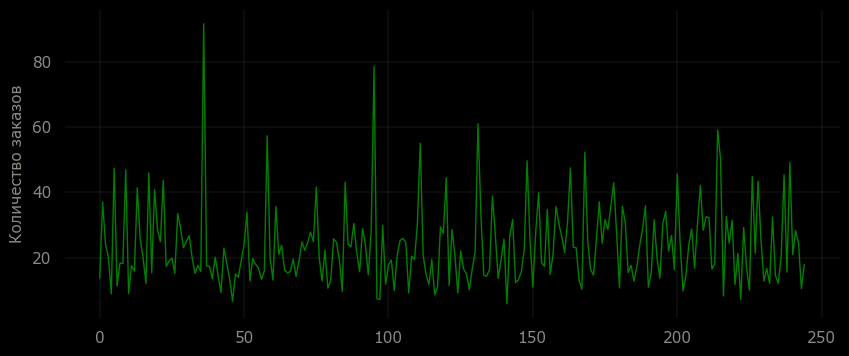

In [1075]:
plt.figure(figsize=(10,4))

df['cnt'] = pd.Series(np.random.lognormal(3, 0.5, size = len(df)))
sns.lineplot(x = df.cnt.index, y = df.cnt.values, color='green',linewidth=1)

plt.tick_params(axis='both', colors='#8b8a84')
plt.xlabel("", labelpad = 5, fontsize= 11,color='#8b8a84')
plt.ylabel("Количество заказов", labelpad = 5, fontsize= 11,color='#8b8a84')
for pos in ['right', 'top', 'bottom', 'left']: 
    plt.gca().spines[pos].set_visible(False)
plt.grid(color='darkgray', linestyle='-', linewidth=0.1)
plt.show()

У нас есть число заказов для каждой даты

In [1076]:
df.head(3)

,date,cnt
0,2024-05-01,13.652668
1,2024-05-02,36.980833
2,2024-05-03,24.080693


Разные заказы с одной датой - это записи с разными id покупателей и с одной и той же датой. 

Каждую дату нужно повторить столько раз, сколько заказов ей соответствует.

In [1077]:
df.cnt = df.cnt.round(0).astype(int) # Округляем число заказов

Превратим дату в список из одного элемента - даты, умножим список на число заказов, получив список длиной в число заказов, суммируем все списки, дописав их один за другим и превратим все в датафрейм

In [1078]:
dt = pd.DataFrame({'date':(df.date.apply(lambda x : [x]) * df.cnt).sum()})
df = dt


In [1079]:
df

,date
0,2024-05-01
1,2024-05-01
2,2024-05-01
3,2024-05-01
4,2024-05-01
...,...
5783,2024-12-31
5784,2024-12-31
5785,2024-12-31
5786,2024-12-31


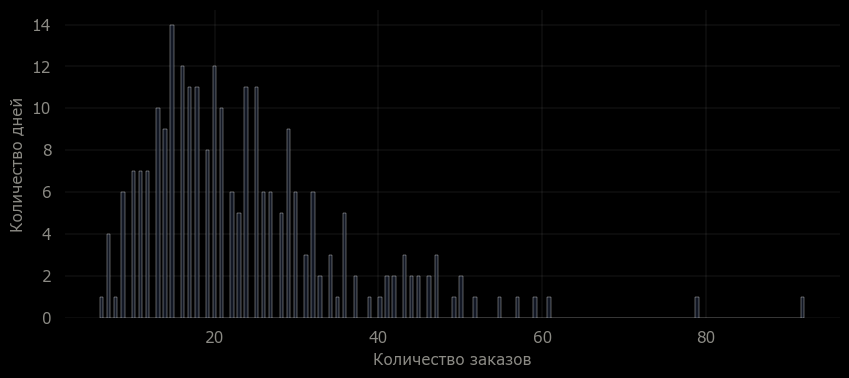

In [1080]:
plt.figure(figsize=(10,4))

sns.histplot(df.date.value_counts(), bins = 200, color='#171e2f')

plt.tick_params(axis='both', colors='#8b8a84')
plt.xlabel("", labelpad = 5, fontsize= 11,color='#8b8a84')
plt.ylabel("Количество дней", labelpad = 5, fontsize= 11,color='#8b8a84')
plt.xlabel("Количество заказов", labelpad = 5, fontsize= 11,color='#8b8a84')
for pos in ['right', 'top', 'bottom', 'left']: 
    plt.gca().spines[pos].set_visible(False)
plt.grid(color='darkgray', linestyle='-', linewidth=0.1)
plt.show()

Теперь дорисуем заказам время. Наберем все секунды в сутках, затем случайным сэмплом выберем из них по нужному числу записей для каждой даты.

Отфильтруем время до 8 утра и после 11 вечера, типа в это время магазин закрыт

In [1081]:
tm = pd.date_range('2020-01-01','2020-01-02', freq = 's').time
tm = pd.Series(tm)
tm = tm[(tm.values > datetime.time(8, 0, 0)) & (tm.values < datetime.time(23, 0, 0))]
tm.head(3)

28801    08:00:01
28802    08:00:02
28803    08:00:03
dtype: object

In [1082]:
dt = pd.DataFrame(df.date.value_counts()).reset_index()
dt.head(3)

,date,count
0,2024-06-06,92
1,2024-08-04,79
2,2024-09-09,61


В Count у нас число секундных интревалов, которые слуйным образом нам надо набрать

In [1083]:
t = []

lst = [tm.sample(dt['count'][i],replace = False) for i in range(len(dt))] # Собираем список списков (набор времен заказа для каждой даты)
lst = pd.Series([item for sublist in lst for item in sublist])            # Превращаем список списков в один сплошной список времен
lst

0       19:31:20
1       14:31:58
2       18:43:25
3       18:22:12
4       16:15:00
          ...   
5783    18:47:18
5784    22:18:23
5785    08:56:19
5786    16:04:14
5787    13:11:12
Length: 5788, dtype: object

In [1084]:
df['time'] = lst
df.head(3)


,date,time
0,2024-05-01,19:31:20
1,2024-05-01,14:31:58
2,2024-05-01,18:43:25


In [1085]:
df['datetime'] = pd.to_datetime(df['date'].astype(str) + ' ' + df['time'].astype(str)) # Соберем дату и время в одно поле

In [1086]:
df = df['datetime'].to_frame()
df.head(3)

,datetime
0,2024-05-01 19:31:20
1,2024-05-01 14:31:58
2,2024-05-01 18:43:25


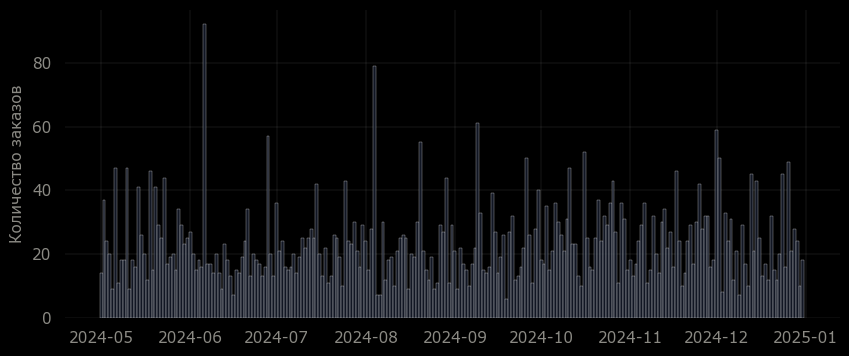

In [1087]:
plt.figure(figsize=(10,4))

sns.histplot(df.datetime.dt.date, bins = 200, color='#171e2f')

plt.tick_params(axis='both', colors='#8b8a84')
plt.xlabel("", labelpad = 5, fontsize= 11,color='#8b8a84')
plt.ylabel("Количество заказов", labelpad = 5, fontsize= 11,color='#8b8a84')
for pos in ['right', 'top', 'bottom', 'left']: 
    plt.gca().spines[pos].set_visible(False)
plt.grid(color='darkgray', linestyle='-', linewidth=0.1)
plt.show()

Один заказ - один пользователь, но в заказе может быть больше одного товара, продажа каждого товара - это запись с одним datetime, одним order_id и одним товаром

Нарисуем id заказов к каждой записи

In [1088]:
df['order_id'] = range(2783590-len(df), 2783590) # возьмем любой диапазон лишь бы разница была в длину df и число цифр на границах было бы одним и тем же (для красоты)
df.head(3)

,datetime,order_id
0,2024-05-01 19:31:20,2777802
1,2024-05-01 14:31:58,2777803
2,2024-05-01 18:43:25,2777804


Пользователей наберем случайно из равномерного распределения

Усложним задачу для реалистичности - не все покупают с регистрацией, то есть не каждый пользователь учтен. 

Пусть у нас будет только около половины зарегистрированных пользователей 

In [1089]:
t = np.random.randint(10000, 100000, 2500)
t

array([98662, 17599, 77360, ..., 43462, 72373, 38263],
      shape=(2500,), dtype=int32)

Теперь эти записи с id пользователей нужно случайно разбавить пропусками - продажами непостоянным клиентам

In [1090]:

t1 = pd.Series([[i] + [0]*pd.Series(np.random.randint(0,4,1))[0] for i in t]).sum()
len(t1)  # Главное чтобы итоговый массив получился длиннее чем df


6154

In [1091]:
t1 = t1[:len(df)] # Подрежем список под длину df
len(t1)

5788

In [1092]:
df['customer_id'] = t1
df

,datetime,order_id,customer_id
0,2024-05-01 19:31:20,2777802,98662
1,2024-05-01 14:31:58,2777803,0
2,2024-05-01 18:43:25,2777804,17599
3,2024-05-01 18:22:12,2777805,0
4,2024-05-01 16:15:00,2777806,77360
...,...,...,...
5783,2024-12-31 18:47:18,2783585,34774
5784,2024-12-31 22:18:23,2783586,0
5785,2024-12-31 08:56:19,2783587,0
5786,2024-12-31 16:04:14,2783588,0


Мы решили, что в заказе может быть больше одного товара, продажа каждого товара - это запись с одним datetime, одним order_id и одним товаром, то есть нужно получить случайное число товаров в заказах и размножить строки в соответствии с этим количеством. Все по аналогии с числом заказов в один день.

Нарисуем товары

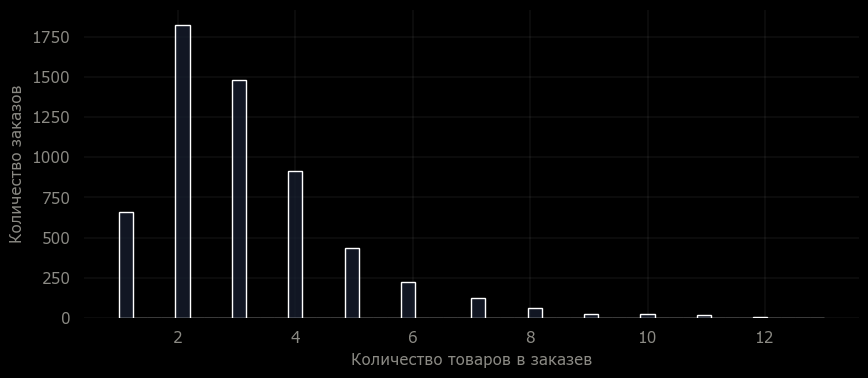

In [1093]:
plt.figure(figsize=(10,4))

df['items_cnt'] = pd.Series(np.random.lognormal(1, 0.5, size = len(df)))
df.items_cnt = df.items_cnt.round(0).astype(int).replace(0,1)

sns.histplot(df.items_cnt, bins = 50, color='#171e2f')

plt.tick_params(axis='both', colors='#8b8a84')
plt.xlabel("", labelpad = 5, fontsize= 11,color='#8b8a84')
plt.ylabel("Количество заказов", labelpad = 5, fontsize= 11,color='#8b8a84')
plt.xlabel("Количество товаров в заказев", labelpad = 5, fontsize= 11,color='#8b8a84')
for pos in ['right', 'top', 'bottom', 'left']: 
    plt.gca().spines[pos].set_visible(False)
plt.grid(color='darkgray', linestyle='-', linewidth=0.1)
plt.show()

In [1094]:
dt = pd.DataFrame({'order_id':(df.order_id.apply(lambda x : [x]) * df.items_cnt).sum()})
dt

,order_id
0,2777802
1,2777802
2,2777802
3,2777803
4,2777804
...,...
17980,2783588
17981,2783588
17982,2783588
17983,2783589


In [1095]:
dt = dt.merge(df, how = 'left', on = 'order_id')

In [1096]:
df = dt[['datetime', 'order_id', 'customer_id']]
df

,datetime,order_id,customer_id
0,2024-05-01 19:31:20,2777802,98662
1,2024-05-01 19:31:20,2777802,98662
2,2024-05-01 19:31:20,2777802,98662
3,2024-05-01 14:31:58,2777803,0
4,2024-05-01 18:43:25,2777804,17599
...,...,...,...
17980,2024-12-31 16:04:14,2783588,0
17981,2024-12-31 16:04:14,2783588,0
17982,2024-12-31 16:04:14,2783588,0
17983,2024-12-31 13:11:12,2783589,41785


Нарисуем товары, пусть их будет 100 шт

In [1097]:
items = pd.Series(['item_' + str(_) for _ in range (100)]).to_frame()
items.columns = ['item']
items['price'] = (np.random.uniform(10, 1000, size= 100)).round(1)
items

,item,price
0,item_0,16.5
1,item_1,306.0
2,item_2,88.0
3,item_3,847.4
4,item_4,969.4
...,...,...
95,item_95,567.2
96,item_96,131.1
97,item_97,205.6
98,item_98,589.0


Нарисуем количество

In [1098]:
df['quantity'] = np.random.randint(1,10, len(df))

Создадим популярность товаров

In [1099]:
items['prob'] = np.random.poisson(10, 100) # Это вероятности покупки товаров
items

,item,price,prob
0,item_0,16.5,14
1,item_1,306.0,5
2,item_2,88.0,7
3,item_3,847.4,11
4,item_4,969.4,11
...,...,...,...
95,item_95,567.2,11
96,item_96,131.1,3
97,item_97,205.6,7
98,item_98,589.0,5


In [1100]:
res = []
for i in range(100):
    res.append([items.item[i]]*items.prob[i])                   # Набираем полную группу событий
lst = pd.Series([item for sublist in res for item in sublist]).to_frame()  # Перевращаем список списков в простой список
lst.columns = ['test']
lst

,test
0,item_0
1,item_0
2,item_0
3,item_0
4,item_0
...,...
974,item_99
975,item_99
976,item_99
977,item_99


In [1101]:
df['item'] = 1
df.head(3)

,datetime,order_id,customer_id,quantity,item
0,2024-05-01 19:31:20,2777802,98662,9,1
1,2024-05-01 19:31:20,2777802,98662,2,1
2,2024-05-01 19:31:20,2777802,98662,4,1


Итак, у нас есть полная группа товаров с соответствующими вероятностями, теперь из нее мы будем сэмплить товар для каждой записи в df

In [1102]:
for i in range(len(df)):
    df.item[i] = lst.test.sample(1, replace = True).values[0]
df

C:\Users\mail\AppData\Local\Temp\ipykernel_22792\3515476002.py:2: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  df.item[i] = lst.test.sample(1, replace = True).values[0]
C:\Users\mail\AppData\Local\Temp\ipykernel_22792\3515476002.py:2: Setti

,datetime,order_id,customer_id,quantity,item
0,2024-05-01 19:31:20,2777802,98662,9,item_99
1,2024-05-01 19:31:20,2777802,98662,2,item_77
2,2024-05-01 19:31:20,2777802,98662,4,item_94
3,2024-05-01 14:31:58,2777803,0,5,item_56
4,2024-05-01 18:43:25,2777804,17599,7,item_89
...,...,...,...,...,...
17980,2024-12-31 16:04:14,2783588,0,1,item_71
17981,2024-12-31 16:04:14,2783588,0,7,item_72
17982,2024-12-31 16:04:14,2783588,0,1,item_99
17983,2024-12-31 13:11:12,2783589,41785,1,item_40


In [1103]:
df = df.merge(items, how = 'left', on = 'item')
df = df[['datetime','order_id','customer_id', 'item', 'price', 'quantity']]
df

,datetime,order_id,customer_id,item,price,quantity
0,2024-05-01 19:31:20,2777802,98662,item_99,334.4,9
1,2024-05-01 19:31:20,2777802,98662,item_77,249.8,2
2,2024-05-01 19:31:20,2777802,98662,item_94,67.3,4
3,2024-05-01 14:31:58,2777803,0,item_56,66.0,5
4,2024-05-01 18:43:25,2777804,17599,item_89,448.1,7
...,...,...,...,...,...,...
17980,2024-12-31 16:04:14,2783588,0,item_71,881.0,1
17981,2024-12-31 16:04:14,2783588,0,item_72,226.8,7
17982,2024-12-31 16:04:14,2783588,0,item_99,334.4,1
17983,2024-12-31 13:11:12,2783589,41785,item_40,828.1,1


In [1104]:
len(df)

17985

Для каждого товара каждого заказа оставим только одну запись

In [1105]:
dfd = pd.DataFrame()
for order in orders:
    dfd = pd.concat([dfd, df[df.order_id == order].drop_duplicates(subset=['item'])])
df = dfd
len(df)

16641

Число записей уменьшилось за счет удаления повторов товара. Добавим скидки для зарегистрированных клиентов (условно по карте)

In [1106]:
df['discount'] = np.where(df['customer_id'] > 0, 0.2, 0)
df.head(3)

,datetime,order_id,customer_id,item,price,quantity,discount
9492,2024-09-12 22:09:58,2780856,0,item_57,640.2,8,0.0
9493,2024-09-12 22:09:58,2780856,0,item_75,969.1,6,0.0
17708,2024-12-27 15:53:53,2783505,0,item_60,976.4,1,0.0


In [1107]:
df['bundle_discount'] = 0.0
df

,datetime,order_id,customer_id,item,price,quantity,discount,bundle_discount
9492,2024-09-12 22:09:58,2780856,0,item_57,640.2,8,0.0,0.0
9493,2024-09-12 22:09:58,2780856,0,item_75,969.1,6,0.0,0.0
17708,2024-12-27 15:53:53,2783505,0,item_60,976.4,1,0.0,0.0
10608,2024-09-29 12:36:41,2781235,81683,item_87,351.9,9,0.2,0.0
10609,2024-09-29 12:36:41,2781235,81683,item_1,306.0,9,0.2,0.0
...,...,...,...,...,...,...,...,...
17420,2024-12-24 18:59:59,2783420,82323,item_20,772.9,4,0.2,0.0
6640,2024-08-03 22:44:01,2779950,0,item_72,226.8,4,0.0,0.0
6641,2024-08-03 22:44:01,2779950,0,item_12,416.2,5,0.0,0.0
6642,2024-08-03 22:44:01,2779950,0,item_53,905.0,8,0.0,0.0


Наконец, создадим еще скидки комплекты, типа купи сосиску вместе с кофе за полцены

Будем считать, что есть пары товаров, которые считаются комплектами, и в случае присутствия пары в заказе - на оба товара дается скидка 50%

Для начала создадим пары товаров, пусть у нас будет 100 таких комплектов

In [1108]:
pd.Series([i for i in range(0,100)]).sample(2,replace=False)

67    67
25    25
dtype: int64

In [1109]:
res = []
for i in range(20):
    t = pd.Series([i for i in range(0,100)]).sample(2,replace=False)
    res.append([items.item[t.values[0]], items.item[t.values[1]]])
bundles = pd.Series(res).to_frame()
bundles.columns = ['bundle']
bundles


,bundle
0,"[item_11, item_53]"
1,"[item_23, item_9]"
2,"[item_48, item_37]"
3,"[item_80, item_57]"
4,"[item_88, item_50]"
5,"[item_35, item_37]"
6,"[item_40, item_77]"
7,"[item_20, item_47]"
8,"[item_49, item_2]"
9,"[item_17, item_55]"


Теперь нужно товарам из заказов, встречающимся парами в одном заказе, нарисовать скидки за комбо в этих заказах

In [1110]:
orders = df.order_id.value_counts().index
orders  # Это список всех заказов

Index([2783223, 2781803, 2781776, 2782212, 2783277, 2779992, 2780987, 2782280,
       2783072, 2783258,
       ...
       2780970, 2778744, 2782690, 2782587, 2782733, 2779189, 2781197, 2779206,
       2781017, 2779975],
      dtype='int64', name='order_id', length=5429)

In [1111]:
for order in orders:
    items_in_order = df[df.order_id == order].item.values
    for i in range(len(bundles)):
        a = bundles.bundle[i][0]
        b = bundles.bundle[i][1]
        if (a in items_in_order) and (b in items_in_order): # Проверяем наличие пары из набора в одном заказе
            # Проверяем равенство количеств в заказе каждого из товаров набора и рисуем скидки
            if df.loc[(df.order_id == order) & (df.item == a), 'quantity'].values[0] == df.loc[(df.order_id == order) & (df.item == b), 'quantity'].values[0]: 
                df.loc[(df.order_id == order) & (df.item == a), 'bundle_discount'] = 0.5
                df.loc[(df.order_id == order) & (df.item == b), 'bundle_discount'] = 0.5
            # Если первого товара набора больше чем второго в одном заказе
            if df.loc[(df.order_id == order) & (df.item == a), 'quantity'].values[0] > df.loc[(df.order_id == order) & (df.item == b), 'quantity'].values[0]: 
                a_idx = df.loc[(df.order_id == order) & (df.item == a), 'bundle_discount'].index
                a_idx = a_idx[0]
                b_idx = df.loc[(df.order_id == order) & (df.item == b), 'bundle_discount'].index
                b_idx = b_idx[0]
                diff = df.loc[(df.order_id == order) & (df.item == a), 'quantity'].values[0] - df.loc[(df.order_id == order) & (df.item == b), 'quantity'].values[0]
                # Расщепляем количество первого товара на равное количеству второго товара и остаток, скидку 50% рисуем только равному количеству, излишек оставляем без скидки
                df = pd.concat([df.iloc[:a_idx + 1], df.loc[a_idx].to_frame().T, df.iloc[a_idx + 1:]]).reset_index(drop=True)
                df.loc[a_idx, 'quantity'] = df.loc[(df.order_id == order) & (df.item == b), 'quantity'].values[0]
                df.loc[a_idx +1, 'quantity'] = diff
                if a_idx < b_idx:
                    df.loc[a_idx, 'bundle_discount'] = 0.5
                    df.loc[b_idx+1, 'bundle_discount'] = 0.5
                else:
                    df.loc[a_idx, 'bundle_discount'] = 0.5
                    df.loc[b_idx, 'bundle_discount'] = 0.5
            # Если первого товара набора меньше чем второго в одном заказе
            if df.loc[(df.order_id == order) & (df.item == a), 'quantity'].values[0] < df.loc[(df.order_id == order) & (df.item == b), 'quantity'].values[0]: 
                a_idx = df.loc[(df.order_id == order) & (df.item == a), 'bundle_discount'].index
                a_idx = a_idx[0]
                b_idx = df.loc[(df.order_id == order) & (df.item == b), 'bundle_discount'].index
                b_idx = b_idx[0]
                diff = df.loc[(df.order_id == order) & (df.item == b), 'quantity'].values[0] - df.loc[(df.order_id == order) & (df.item == a), 'quantity'].values[0]
                # Расщепляем количество первого товара на равное количеству второго товара и остаток, скидку 50% рисуем только равному количеству, излишек оставляем без скидки
                df = pd.concat([df.iloc[:b_idx + 1], df.loc[b_idx].to_frame().T, df.iloc[b_idx + 1:]]).reset_index(drop=True)
                df.loc[b_idx, 'quantity'] = df.loc[(df.order_id == order) & (df.item == a), 'quantity'].values[0]
                df.loc[b_idx +1, 'quantity'] = diff
                if a_idx < b_idx:
                    df.loc[a_idx, 'bundle_discount'] = 0.5
                    df.loc[b_idx, 'bundle_discount'] = 0.5
                else:
                    df.loc[a_idx+1, 'bundle_discount'] = 0.5
                    df.loc[b_idx, 'bundle_discount'] = 0.5

В итоге товарам, парой входящим в одну из пар комплектов и в один заказ мы дорисовали скидку на комплект в 50%, при этом скидка назначается толькона одинаковое количество товара из комплекта 1+1, 2+2, 3+3  и т.д. остаток выносится в отдельную запись без скидки

то есть, если  item-1 и item_2 являются комплектом, на который распространяется скидка, но в заказе этоих товаров 8 и 3 соответственно, то в итоге в датафрейме будут такие записи:

- item-1 3 шт со скидкой
- item-1 5 шт без скидки
- item-2 3 шт со скидкой

например

In [ ]:
df[df.order_id == 2781803]

,datetime,order_id,customer_id,item,price,quantity,discount,bundle_discount
1732,2024-10-21 10:59:26,2781803,0,item_75,969.1,1,0.0,0.0
1733,2024-10-21 10:59:26,2781803,0,item_11,239.4,8,0.0,0.0
1734,2024-10-21 10:59:26,2781803,0,item_92,676.7,5,0.0,0.0
1735,2024-10-21 10:59:26,2781803,0,item_88,25.2,1,0.0,0.5
1736,2024-10-21 10:59:26,2781803,0,item_39,962.0,1,0.0,0.5
1737,2024-10-21 10:59:26,2781803,0,item_39,962.0,6,0.0,0.0
1738,2024-10-21 10:59:26,2781803,0,item_43,172.1,2,0.0,0.0
1739,2024-10-21 10:59:26,2781803,0,item_68,242.1,1,0.0,0.0
1740,2024-10-21 10:59:26,2781803,0,item_34,419.1,9,0.0,0.0
1741,2024-10-21 10:59:26,2781803,0,item_41,267.3,6,0.0,0.0


In [1114]:
df

,datetime,order_id,customer_id,item,price,quantity,discount,bundle_discount
0,2024-09-12 22:09:58,2780856,0,item_57,640.2,8,0.0,0.0
1,2024-09-12 22:09:58,2780856,0,item_75,969.1,6,0.0,0.0
2,2024-12-27 15:53:53,2783505,0,item_60,976.4,1,0.0,0.0
3,2024-09-29 12:36:41,2781235,81683,item_87,351.9,9,0.2,0.0
4,2024-09-29 12:36:41,2781235,81683,item_1,306.0,9,0.2,0.0
...,...,...,...,...,...,...,...,...
16730,2024-12-24 18:59:59,2783420,82323,item_20,772.9,4,0.2,0.0
16731,2024-08-03 22:44:01,2779950,0,item_72,226.8,4,0.0,0.0
16732,2024-08-03 22:44:01,2779950,0,item_12,416.2,5,0.0,0.0
16733,2024-08-03 22:44:01,2779950,0,item_53,905.0,8,0.0,0.0


Тут можно было бы еще поупражнятся с остатсками по складу, скидками вида 1+1 = 3 и так далее, но если надо будет - можно будет развить на основе этой заготовки